# Introduction

Nama : Gentur Herlambang

Batch : FTDS-017-RMT

Dataset : data yang di scarp dari twiter mengenai pemilu 2017 , dan di lakukan sentimental analisis.

Objective : dapat membuat model yang mamapu memeprediksi sentimen dari sebuah kalimat/tweet yang berhubngan dengan pemilu 2017 dan menganalisa kata-kata yang paling berasosiasi dengan masing-smasing sentimen . model yang akan di gunan akan meggunakan basis ANN dense, LSTM , dan GRU

In [8]:
## Import libararies untuk data Loading dan EDA
import pandas as pd 
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import warnings; warnings.simplefilter('ignore')


## Import libararies Preprocessing
import string
import re
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
!pip install pysastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding





# Import libararies Model Building
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D,  LSTM, GRU, Dropout
from tensorflow.keras.layers import BatchNormalization,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras import Model
from sklearn.metrics import classification_report#

## Import libararies Model Inference
import pickle
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gentur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gentur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# load data
pd.set_option('display.max_columns',None)
df=pd.read_csv(r'D:\Hack8 Data Science\Phase 2\Milestone\Milestone 2\milestone_2_XX.csv' ) ##Menload data 
df

,tweet,sentimen
0,rt @napqilla: no 1 3 ambisinya menguasai rakya...,1
1,rt @pandji: nah gue pikir sentimen petahana ok...,1
2,rt @pandji: urutan pertama best moment #debat2...,1
3,rt @pandji: ini artikel yg menjelaskan ternyat...,1
4,rt @mrtampi: agus makin santai.\nahok makin sa...,0
...,...,...
1501,rt @erixputra: rakyat adalah bos kami. kami ad...,1
1502,ahok \u2013 djarot waspadai politik uang dalam...,1
1503,@jokowi harusnya sdh tahu dari awal ini semaki...,1
1504,#coblosnomor2 soal transportasi ahok sebut ani...,0


0 itu positif dan 1 negatif

mengecek apakah ada missing value

In [10]:
# cek missing value
copy=df.copy()
copy.isnull().sum()

tweet       0
sentimen    0
dtype: int64

tidak ada missing value

In [11]:
# cek persebaran target
copy.sentimen.value_counts()

1    757
0    749
Name: sentimen, dtype: int64

Jumlah datanya seimbang

# Preprocesing

para proses preprocesing kan menghilangkan kata dan karakter yang tidak relevan dan menggagu proses model learingnya dan mempersiapkan token dan embeding untuk model training

In [12]:
# membuat copy untuk preprocesing
teks=copy.copy()
teks

,tweet,sentimen
0,rt @napqilla: no 1 3 ambisinya menguasai rakya...,1
1,rt @pandji: nah gue pikir sentimen petahana ok...,1
2,rt @pandji: urutan pertama best moment #debat2...,1
3,rt @pandji: ini artikel yg menjelaskan ternyat...,1
4,rt @mrtampi: agus makin santai.\nahok makin sa...,0
...,...,...
1501,rt @erixputra: rakyat adalah bos kami. kami ad...,1
1502,ahok \u2013 djarot waspadai politik uang dalam...,1
1503,@jokowi harusnya sdh tahu dari awal ini semaki...,1
1504,#coblosnomor2 soal transportasi ahok sebut ani...,0


kemudian membuat funsi yang akan membersihkan kata dan karakter yang di rasa tidak relevan
- Menghilangkan @ dan # yang hanya berguna di twiietr
- membuat semua huruf menajdi lower case aagr tidak terjadi duplikasi 
- menghilangkan kata yang yang engaundg link karena tidak bisa di cerna
- menghilangkan emoji dan angka, meskipun di sini angka bisa bermaskud no calon sperti " si-2 baik" maksud si -2 adalah paslon no 2 tetapi saya memilih untuk menghilangkan karena ini terlalu rancu dan harus di lakukan untuk case-by-case
- menghilangkan white space agar semua kata memiliki awalan yang sama "ayah" dan " ayah" akan berbeda dengan menghilangkan white space maka kedua kata itu akan menajdi sama

In [13]:
# Membuuat Sebuah Function Agar Dapat Diterapkan pada DataFrame

def text_proses(teks):
  # Mengubah Teks ke Lowercase
  teks = teks.lower()
  
  # Menghilangkan Mention
  teks = re.sub("@[A-Za-z0-9_]+", " ", teks)
  
  # Menghilangkan Hashtag
  teks = re.sub("#[A-Za-z0-9_]+", " ", teks)
  
  # Menghilangkan \n
  teks = re.sub(r"\\n", " ",teks)
  
  # Menghilangkan Whitespace
  teks = teks.strip()

  # Menghilangkan Link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # Menghilangkan RT
  teks = re.sub("rt", " ",teks)
   



  # Melakukan Tokenisasi
  tokens = word_tokenize(teks)

  # Menghilangkan Stopwords
  stpwds_id = list(set(stopwords.words('indonesian')))
  teks = ' '.join([word for word in tokens if word not in stpwds_id])
  
  # Melakukan Stemming
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  teks = stemmer.stem(teks)
  
  return teks

kemudian mengapply fungsi baru pada data yang ada agar dapat melihat perbedaanya

In [14]:
# membuat kolom baru yang berisi data yang sudah di bersihkan
teks['bersih'] = teks['tweet'].apply(lambda x: text_proses(x))
teks

,tweet,sentimen,bersih
0,rt @napqilla: no 1 3 ambisinya menguasai rakya...,1,no ambisi kuasa rakyat no ambisi layan rakyat ...
1,rt @pandji: nah gue pikir sentimen petahana ok...,1,gue pikir sentimen tahana oke malam mn politic...
2,rt @pandji: urutan pertama best moment #debat2...,1,urut pe ama best moment basuki misahin bu sylv...
3,rt @pandji: ini artikel yg menjelaskan ternyat...,1,a ikel yg yg dapet respon positif socmed
4,rt @mrtampi: agus makin santai.\nahok makin sa...,0,agus santai ahok santun anies esmosi imho
...,...,...,...
1501,rt @erixputra: rakyat adalah bos kami. kami ad...,1,rakyat bos layan rakyat u d u ahok rame rame
1502,ahok \u2013 djarot waspadai politik uang dalam...,1,ahok u djarot waspada politik uang pilkada
1503,@jokowi harusnya sdh tahu dari awal ini semaki...,1,sdh masifhidupkan uu surversib presiden href r...
1504,#coblosnomor2 soal transportasi ahok sebut ani...,0,transpo asi ahok anies baca uu besok baca ya


untuk lebih membersihkannya lagi akan menghapus kata yang hanya terdiri dari 1-3 huruf karena di rasa kurang relevan ('u', 'ty', 'no') dan kata yang hilang maksudnya karena di stem sperti "jakarta" menajdi "jak" maka saya memilih untuk menghilangakan .

In [15]:
# menghingkan kata-kata pendek yang terdiri dari 1-3 huruf
pendek=re.compile(r'\w*\b\w{1,3}\b')
teks.bersih=teks.bersih.apply(lambda x:pendek.sub('',x))
teks
teks.shape

(1506, 3)

kemudian melakukan train test split dengan pembagian 70 & di gunakan untuk training dan sisanya 30 % untuk train/validasi.

In [16]:
#train test split untuk perispan modeling 
X_train, X_test, y_train, y_test = train_test_split(teks.bersih, 
                                                    teks.sentimen, 
                                                    test_size=0.3, 
                                                    random_state=35, 
                                                    )

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1054,)
Test Size  :  (452,)


Melakukan ekstraksi fitur dari teks dengan countvectorizer

In [17]:
# melakukan ektarksi fitur dari teks
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<1054x1738 sparse matrix of type '<class 'numpy.int64'>'
	with 7209 stored elements in Compressed Sparse Row format>

melakuan pengecekan jumlah vocab dan jumlah kalimat terpanjang untuk embeding

In [18]:
# cek jumlah vocab dan kalimat terpanjang
jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  1738
Panjang maksimum kalimat :  167 kata


jadi dari data terdapat 1738 macam vocab dan kalimat terpanjang terdidari 167 kata

kemudian melakukan mengubah string mendai angka dengan textvectorization agar komputer dapat mengolah data

In [19]:
# mengubah string menjadi angka
text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) # Jika ingin menggunakan Sequential API
                                       )

text_vectorization.adapt(X_train)

kemudian mekaukan embeding agak hadil nya mejadi matrik agar bisa di proses

In [20]:
# Proses Embeding

embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

kemudian mengecek top 20 token , dengan tujuan mngechek top token akan sering di gunkan sebagai bahan belajar

In [21]:
# Melihat Top 30 Token (Diurutkan Berdasarkan Frekuensi Kemunculan Terbesar)

text_vectorization.get_vocabulary()[:30]

['',
 '[UNK]',
 'ahok',
 'agus',
 'anies',
 'pilih',
 'jaka',
 'pilkada',
 'pikir',
 'paslon',
 'pimpin',
 'data',
 'bahaya',
 'dukung',
 'salah',
 'alas',
 'rachmawati',
 'rakyat',
 'megawati',
 'kalah',
 'djarot',
 'orang',
 'survei',
 'masyarakat',
 'yudhoyono',
 'urus',
 'debat',
 'bangun',
 'kejut',
 'potensial']

overall semua token yang yang sering muncul cukup relevan dengan objective dan masih masuk batasan runag lingkup nya yaitu pemilu 2017

melihat proses perubahan dari sring mendai vector dan akhirnya di embed

In [22]:


## Contoh Document
print('Contoh Document')
print(teks.bersih[6])
print('')

## Hasil Text Vectorization
print('Hasil Text Vectorization')
print(text_vectorization([teks.bersih[6]]))
print('Ukuran vector : ', text_vectorization([teks.bersih[6]]).shape)
print('')

## Hasil Embedding
print('Hasil Embedding')
print(embedding(text_vectorization([teks.bersih[6]])))
print('Ukuran vector : ', embedding(text_vectorization([teks.bersih[6]])).shape)

Contoh Document
pdip sengaja becah belah rakyat warga  pilih ahok  

Hasil Text Vectorization
tf.Tensor(
[[ 91 127 144 116  17  50   5   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]], shape=(1, 167), dtype=int64)
Ukuran vector :  (1, 167)

Hasil Embedding
tf.Tensor(
[[[-0.0368493   0.02063345 -0.04452502 ...  0.04471846 -0.04873711
    0.03511177]
  [ 0.02200958 -0.04355657  0.01520106

# EDA

pada bagian ini akan melakukan ekpolrasi sedrhana tentang data yang ada

pertama akan mlihat persebaran data

Text(0.5, 1.0, 'sentimen')

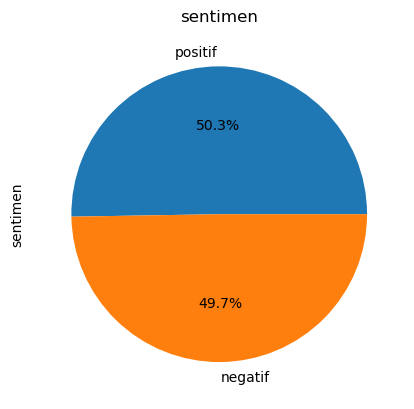

In [23]:
# melihat persebaran data 
copy['sentimen'].value_counts().plot.pie(labels=['positif','negatif'], autopct='%1.1f%%') 
plt.title('sentimen')

Bisa dikatakan data yang dimiliki balance dengan persebaran hampir 50-50

kemudain akan melihat kata yang paling sering muncul dari data asli dan data yang sudah di bersihkan

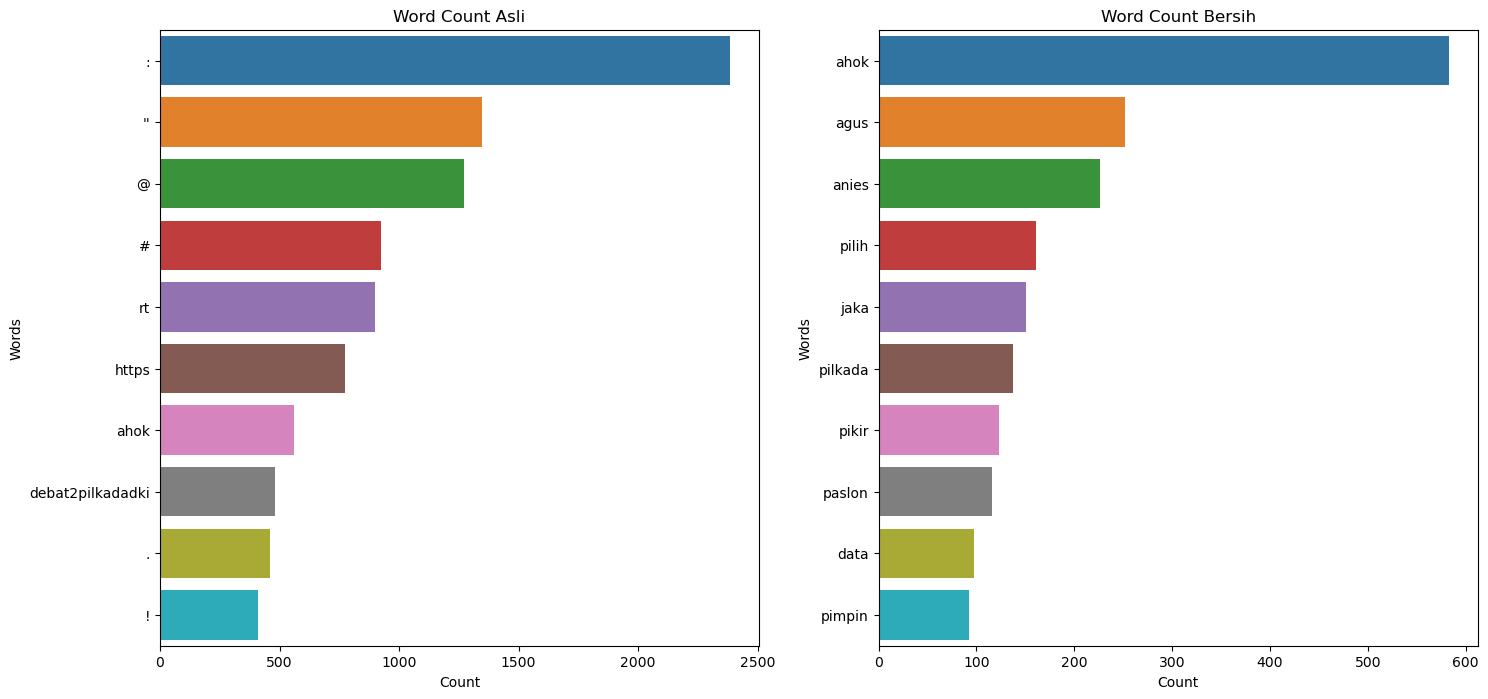

In [24]:
plt.figure(figsize=(17,8))
# word count asli
plt.subplot(1,2,1)
count_asli = " ".join(teks['tweet'])
tokenize = word_tokenize(count_asli)
frequency = Counter(tokenize)
df = pd.DataFrame(frequency.most_common(10))
word_count = sns.barplot(x = df[1], y = df[0])
word_count.set_title("Word Count Asli")
word_count.set_ylabel("Words")
word_count.set_xlabel("Count");
# word count bersih
plt.subplot(1,2,2)
count_bersih = " ".join(teks['bersih'])
tokenize = word_tokenize(count_bersih)
frequency = Counter(tokenize)
df = pd.DataFrame(frequency.most_common(10))
word_count = sns.barplot(x = df[1], y = df[0])
word_count.set_title("Word Count Bersih")
word_count.set_ylabel("Words")
word_count.set_xlabel("Count");

terlihat dari data asli masih banyak kata dan karrakter yang tidak penting dan di data yang telah di bersihkan semua katanya memiki relevansi terhadap subject nya yaitu pemilu 2017

selanjutnya akan melihat jumlah kata pada kalimat pada data asli dan bersih

Text(0.5, 1.0, 'Word Count Bersih')

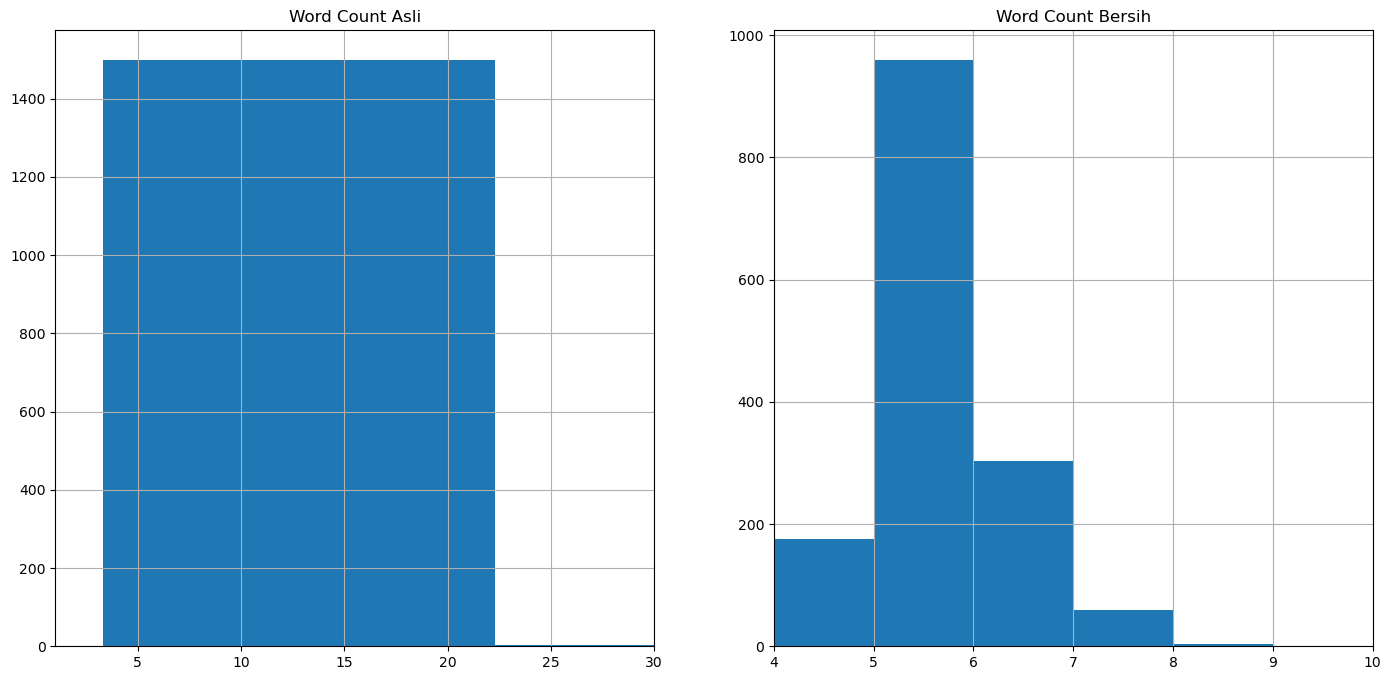

In [25]:
plt.figure(figsize=(17,8))
# jumlah kata data asli
plt.subplot(1,2,1)
teks['tweet'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.xlim([1, 30])
plt.title('Word Count Asli')
# jumlah kata data bersih
plt.subplot(1,2,2)
teks['bersih'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.xlim([4, 10])
plt.title('Word Count Bersih')

terlihat perubhana dari data asli , data yang bersih terlihat lebih relaistic 

terakhir membuat word cloud yang menggabrakan kata-kata yang paling seriing muncul untuk sentimen positif dan negatif

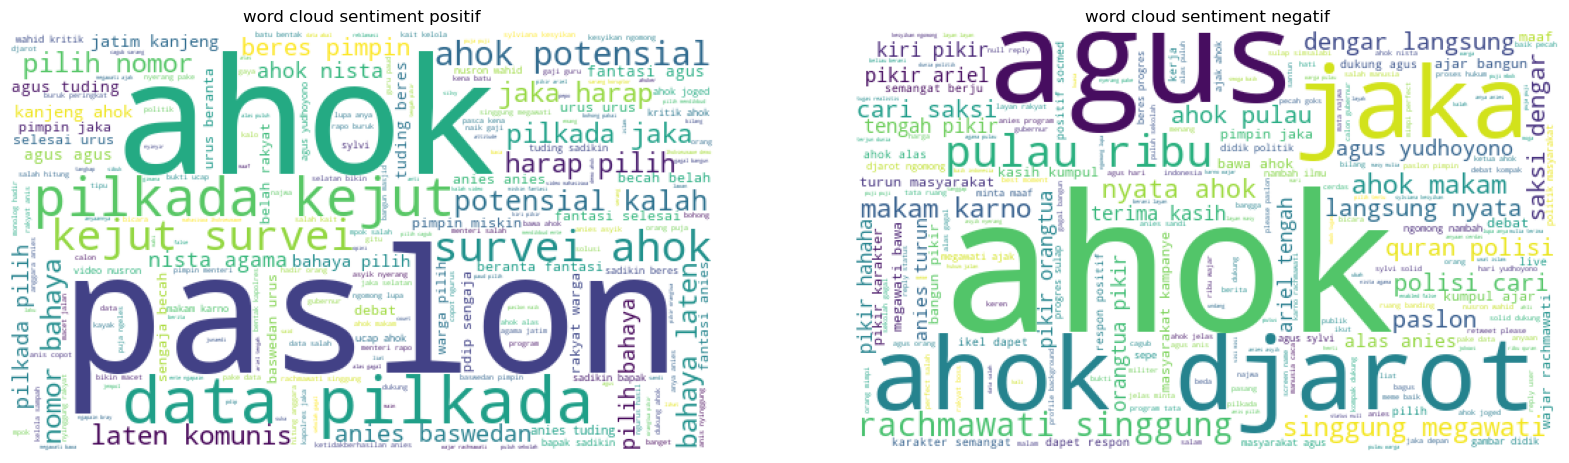

In [26]:
plt.figure(figsize=(20,10))
# word cloud positif
plt.subplot(1,2,1)
word_cloud = teks.loc[teks.sentimen ==0, 'bersih']
k = (' '.join(word_cloud))
wordcloud = WordCloud(width=500, height=300, background_color='white').generate(k)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('word cloud sentiment positif');
# word cloud negatif
plt.subplot(1,2,2)
word_cloud = teks.loc[teks.sentimen ==1, 'bersih']
k = (' '.join(word_cloud))
wordcloud = WordCloud(width=500, height=300, background_color='white').generate(k)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('word cloud sentiment negatif');

disini terlihat ahok sangan mendominasi baik di sentimen positif maupun negatif , dan juga nama pasangan dan calon lainya juga cukup besar dan berpengaruh, tetapi yang menarik nama ahok cukup relveant baik di sentimen positif ataupun negatif , ini menenjukan betapa biplornya image ahok apda pilkada 2017.

# Model Building

untuk pembuatan model semua aristektur model akan di mulai dari jumlah neuron yang besar dan pada maju ke layer berikutnya jumlah neuronya mulai mngecil , alasan saya membuat seperti ini karena mocel ANN di buat berdasarkan cara otak manusia berpikir dan manusai bisasanya lebih baik belajar dari hal yang genereal dan semakin jauh semakin spesifik sehingga arsitektur model yang menyerupai cara manusia belajar dan berpikir.

penambahan pipeline untuk ann agar data yang tersbar lebih merata dengan shuffle dan prefetch agar prosses training labih effisisen sehingga dapat mengguaragi waktu training nya

In [27]:
# Pendefinisan pipeline tensor
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(64).shuffle(100).prefetch(tf.data.AUTOTUNE)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(64)

# model 1

pada model ini hayanya akan menggunakan model ANN dense normal yang akan di gunakan sebagai baseline model ini 6 hidden layer yang di mulai dari 128 neuron terus mengecil hingga hanya menjadi 4 neuron sebelum masuk ke output layer.

In [86]:
# Pendefinisan pipeline tensor
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(64).shuffle(100).prefetch(tf.data.AUTOTUNE)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(64)

## model building

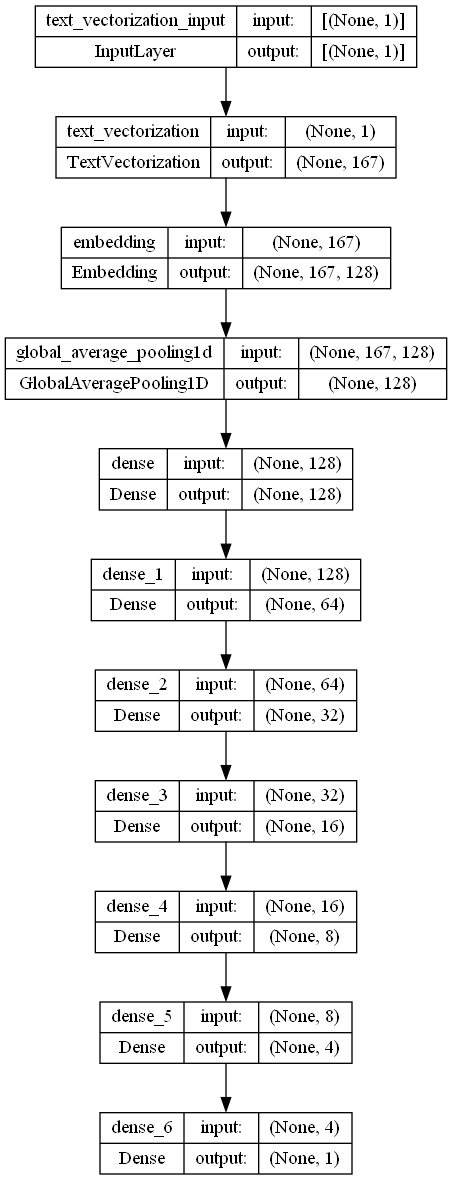

In [21]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# model architecture
model_1= Sequential()
model_1.add(text_vectorization)
model_1.add(embedding)
model_1.add(GlobalAveragePooling1D())
model_1.add(Dense(128,activation='relu'))
model_1.add(Dense(64,activation='relu'))
model_1.add(Dense(32,activation='relu'))
model_1.add(Dense(16,activation='relu'))
model_1.add(Dense(8,activation='relu'))
model_1.add(Dense(4,activation='relu'))
model_1.add(Dense(1,activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_1, show_shapes=True)


## model training

In [93]:
# model training
model_dnn_hist_1 = model_1.fit(train_pipe,
                         epochs=50,
                         validation_data=test_pipe)

Epoch 1/50
33/33 [==============================] - 1s 14ms/step - loss: 1.3378 - accuracy: 0.6822 - auc: 0.7766 - val_loss: 0.4841 - val_accuracy: 0.7588 - val_auc: 0.8425
Epoch 2/50
33/33 [==============================] - 0s 9ms/step - loss: 0.1740 - accuracy: 0.9326 - auc: 0.9826 - val_loss: 1.0186 - val_accuracy: 0.7611 - val_auc: 0.8352
Epoch 3/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1595 - accuracy: 0.9374 - auc: 0.9864 - val_loss: 1.3381 - val_accuracy: 0.7190 - val_auc: 0.8366
Epoch 4/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1325 - accuracy: 0.9393 - auc: 0.9897 - val_loss: 1.1052 - val_accuracy: 0.7389 - val_auc: 0.8421
Epoch 5/50
33/33 [==============================] - 0s 6ms/step - loss: 0.1309 - accuracy: 0.9412 - auc: 0.9905 - val_loss: 1.0811 - val_accuracy: 0.7588 - val_auc: 0.8387
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.1251 - accuracy: 0.9345 - auc: 0.9909 - val_loss: 1.3438 - val_ac

## model evaluation

<AxesSubplot:>

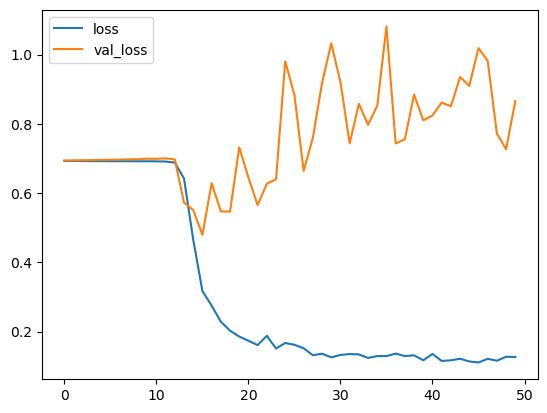

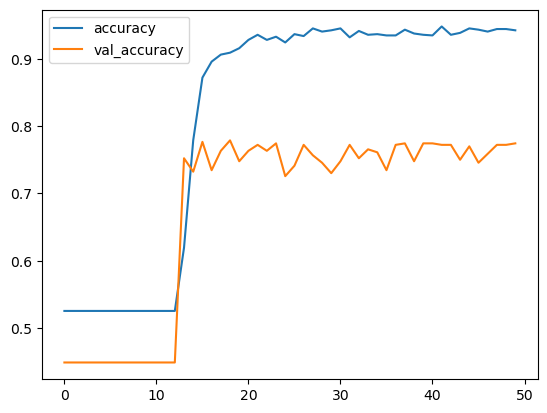

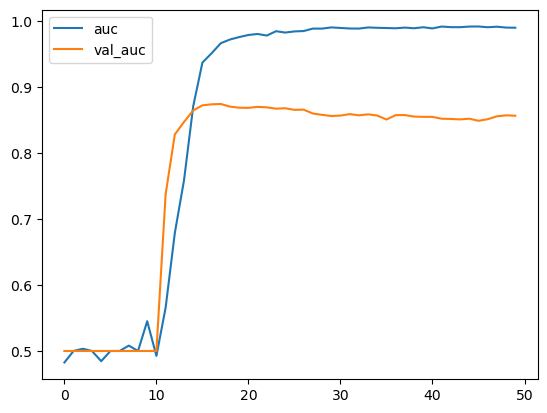

In [23]:
metrics = pd.DataFrame(model_dnn_hist_1.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

unutk modelbaseline hasil lossnya masih nuruk karean tmasih exploding dan terdapat vanishing gradient untuk parameter maka model sealnjutnaya akan di buat untuk meminalisir hal tersebut

In [24]:
y_pred_func = model_1.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       249
           1       0.68      0.93      0.79       203

    accuracy                           0.77       452
   macro avg       0.80      0.79      0.77       452
weighted avg       0.81      0.77      0.77       452



unutk model baseline hasil lossnya terlihat fenomena exploding  dan terdapat vanishing gradient untuk parameter accuracy dan auc yang gap nya sebesar 10-15%, model sealnjutnaya akan di buat untuk meminalisir hal tersebut , sedangkan berdasarkan callsification report ini memiliki acuuracy 77% tetapi hasil ini masih belum stabil.

# model 2

untuk model ke 2 saya akan menabhakan batch normalization yang berguna untuk menguarangi vanishing gradient berdasarkan artikel berikut (https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484)

## model building

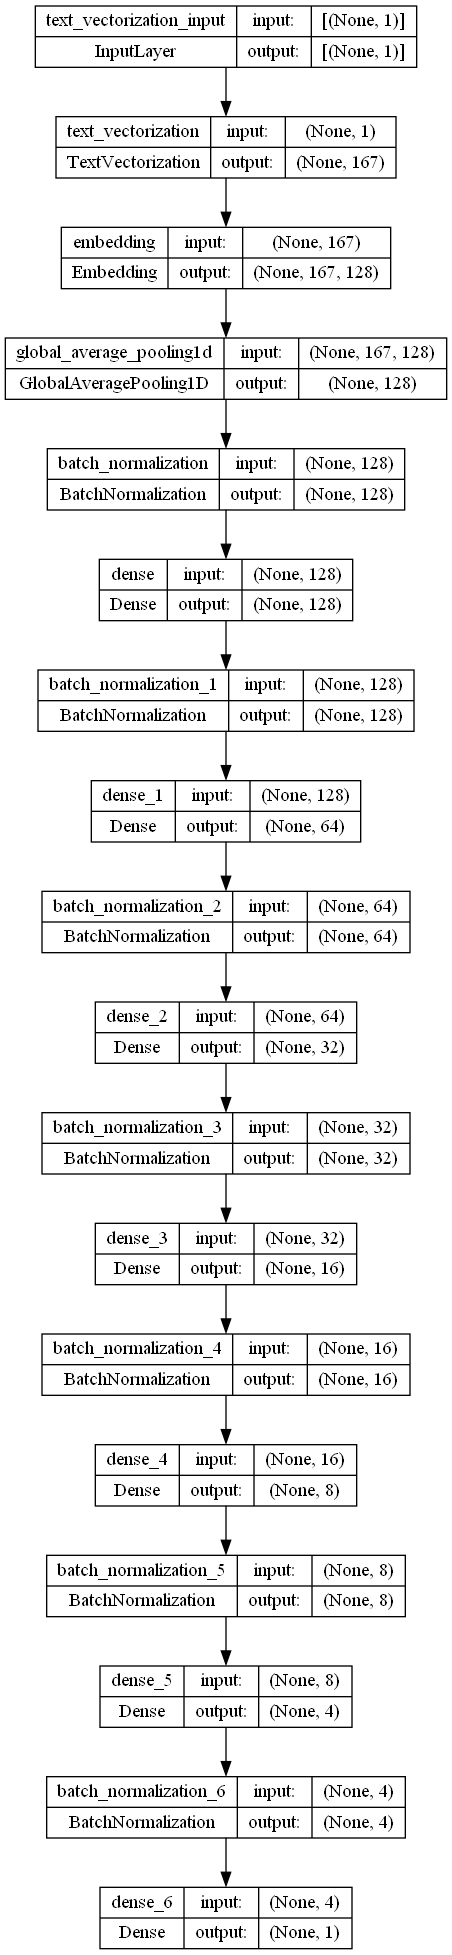

In [64]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# model architecture
model_2= Sequential()
model_2.add(text_vectorization)
model_2.add(embedding)
model_2.add(GlobalAveragePooling1D())
model_2.add(BatchNormalization())
model_2.add(Dense(128,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(64,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(32,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(16,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(8,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(4,activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(1,activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_2, show_shapes=True)

## model training

In [65]:
# model training
model_ann_hist_2 = model_2.fit(train_pipe,
                         epochs=50,
                         validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 4s 21ms/step - loss: 0.6138 - accuracy: 0.6651 - auc: 0.7260 - val_loss: 0.6942 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.4900 - accuracy: 0.8235 - auc: 0.9203 - val_loss: 0.6942 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 3/50
17/17 [==============================] - 0s 9ms/step - loss: 0.4234 - accuracy: 0.8757 - auc: 0.9616 - val_loss: 0.6938 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 4/50
17/17 [==============================] - 0s 9ms/step - loss: 0.3711 - accuracy: 0.9137 - auc: 0.9759 - val_loss: 0.6957 - val_accuracy: 0.4491 - val_auc: 0.5425
Epoch 5/50
17/17 [==============================] - 0s 9ms/step - loss: 0.3267 - accuracy: 0.9222 - auc: 0.9798 - val_loss: 0.6941 - val_accuracy: 0.4491 - val_auc: 0.6770
Epoch 6/50
17/17 [==============================] - 0s 9ms/step - loss: 0.2899 - accuracy: 0.9307 - auc: 0.9818 - val_loss: 0.6895 - val_ac

## model evaluation

<AxesSubplot:>

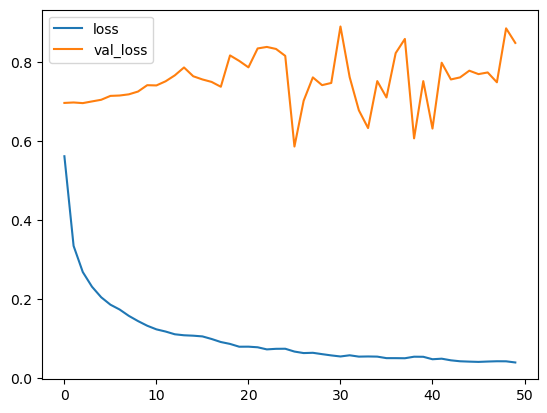

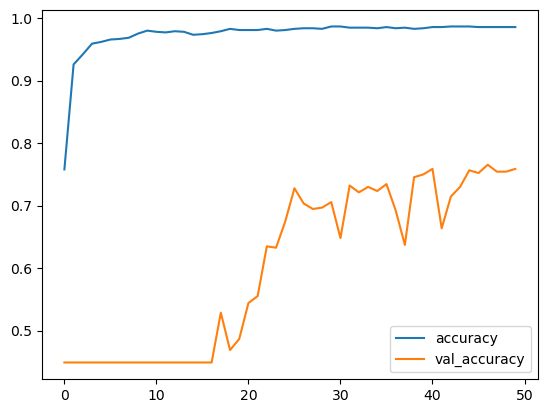

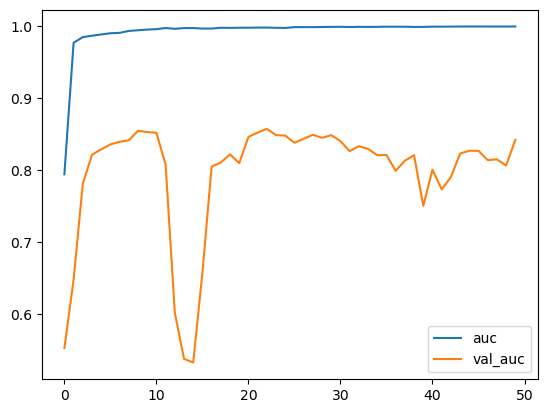

In [28]:
# melihat performansi model
metrics = pd.DataFrame(model_ann_hist_2.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [66]:
# membuat classification repot
y_pred_func_2 = model_2.predict(X_test)
y_pred_func_2 = np.where(y_pred_func_2 >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func_2))

15/15 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.55      0.69       249
           1       0.63      0.95      0.76       203

    accuracy                           0.73       452
   macro avg       0.78      0.75      0.72       452
weighted avg       0.79      0.73      0.72       452



untuk performa model 2 ini bisa dikatakan menurun karena pada loss nya masih belum menurun dan dari segi matriks nyaterjadi fenomena exploding dan vanisinhg secara bersamaaan , tetapi dari classfication report hanya terjadi 4% penuruan acuucary menjadi 73% , apa bila di baningkan dengan baseline nya di model 1 saya bilang tidak terjadi peningkatan.

# model 3

unutuk model selanjutnya akan menggunakan droput yang dapat mengurangi overfitting , karena saya berpikir hasil train selalu lebih baik dari hasi validasi ini merupakan gejala dari overfitting.

## model building

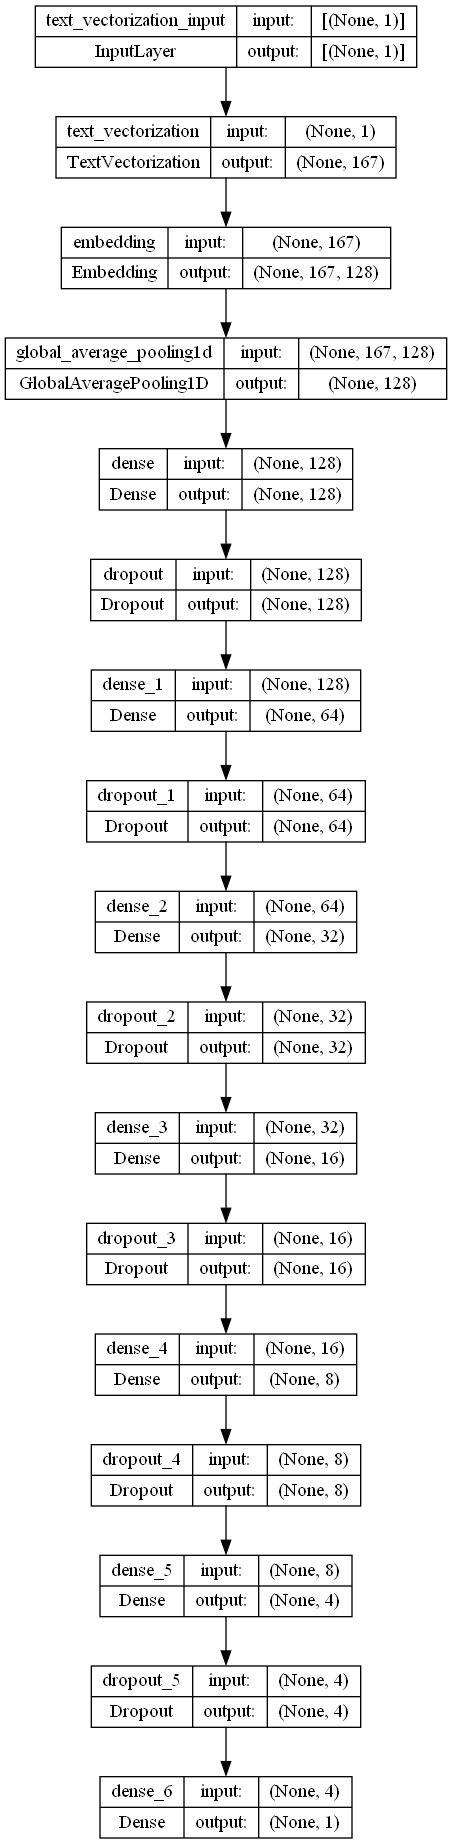

In [30]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# model architecture
model_3= Sequential()
model_3.add(text_vectorization)
model_3.add(embedding)
model_3.add(GlobalAveragePooling1D())
model_3.add(Dense(128,activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(64,activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(32,activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(16,activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(8,activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(4,activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(1,activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_3, show_shapes=True)

## model training

In [31]:
# model training
model_ann_hist_3 = model_3.fit(train_pipe,
                         epochs=50,
                         validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 5s 40ms/step - loss: 0.6929 - accuracy: 0.5180 - auc: 0.4981 - val_loss: 0.6934 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 0.6928 - accuracy: 0.5142 - auc: 0.4975 - val_loss: 0.6937 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 3/50
17/17 [==============================] - 0s 14ms/step - loss: 0.6916 - accuracy: 0.5161 - auc: 0.5164 - val_loss: 0.6940 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 4/50
17/17 [==============================] - 0s 15ms/step - loss: 0.6917 - accuracy: 0.5038 - auc: 0.5153 - val_loss: 0.6941 - val_accuracy: 0.4491 - val_auc: 0.5374
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 0.6838 - accuracy: 0.5228 - auc: 0.5405 - val_loss: 0.6938 - val_accuracy: 0.4491 - val_auc: 0.8163
Epoch 6/50
17/17 [==============================] - 0s 14ms/step - loss: 0.6859 - accuracy: 0.5228 - auc: 0.5272 - val_loss: 0.6859 - v

## model evaluation

<AxesSubplot:>

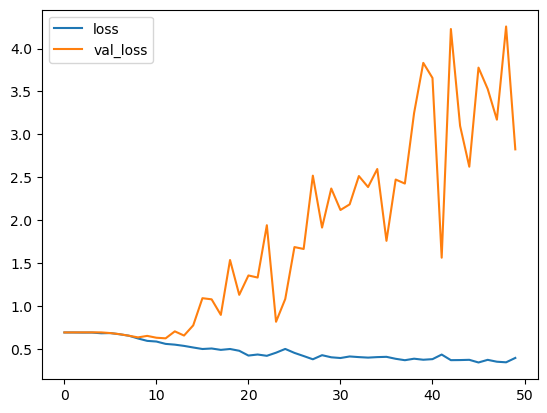

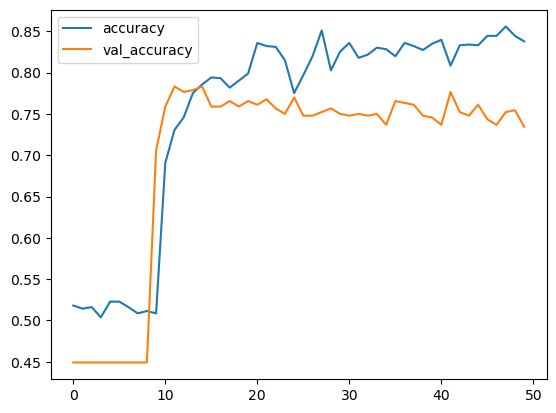

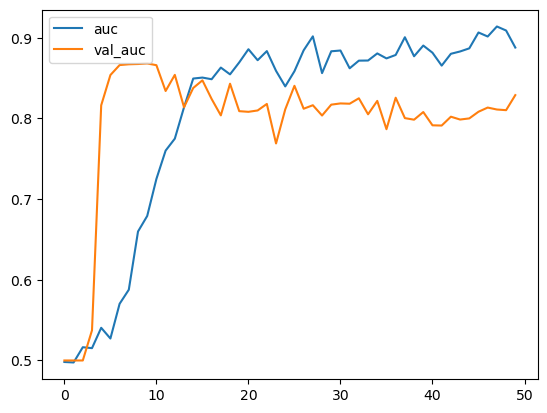

In [32]:
# melihat performansi model

metrics = pd.DataFrame(model_ann_hist_3.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [33]:

# membuat classification repot
y_pred_func = model_3.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       249
           1       0.65      0.87      0.75       203

    accuracy                           0.73       452
   macro avg       0.75      0.75      0.73       452
weighted avg       0.76      0.73      0.73       452



Unutk model ke 3 terjadi peningkatan di banding ke-2 model baseline nya sebelumnya nilai metriks dari accuracy dan auc ikut naik bersama dengan train dan gap nya menipis hanya menjadi 5-8% , akan tetapi nilai val loss nya masih meningkat , ini masih bisa di tingkatakn., tetapi untuk accuracynya berdasarkan calsification report menurun menjadi 73%

# model 4

untuk model 4 saya akan menggabungkan tehnik dari 2 model sebelumnya yaitu batch normalization dan droput dengan harapan dapat menghasilkan model yang lebih baik.

## model building

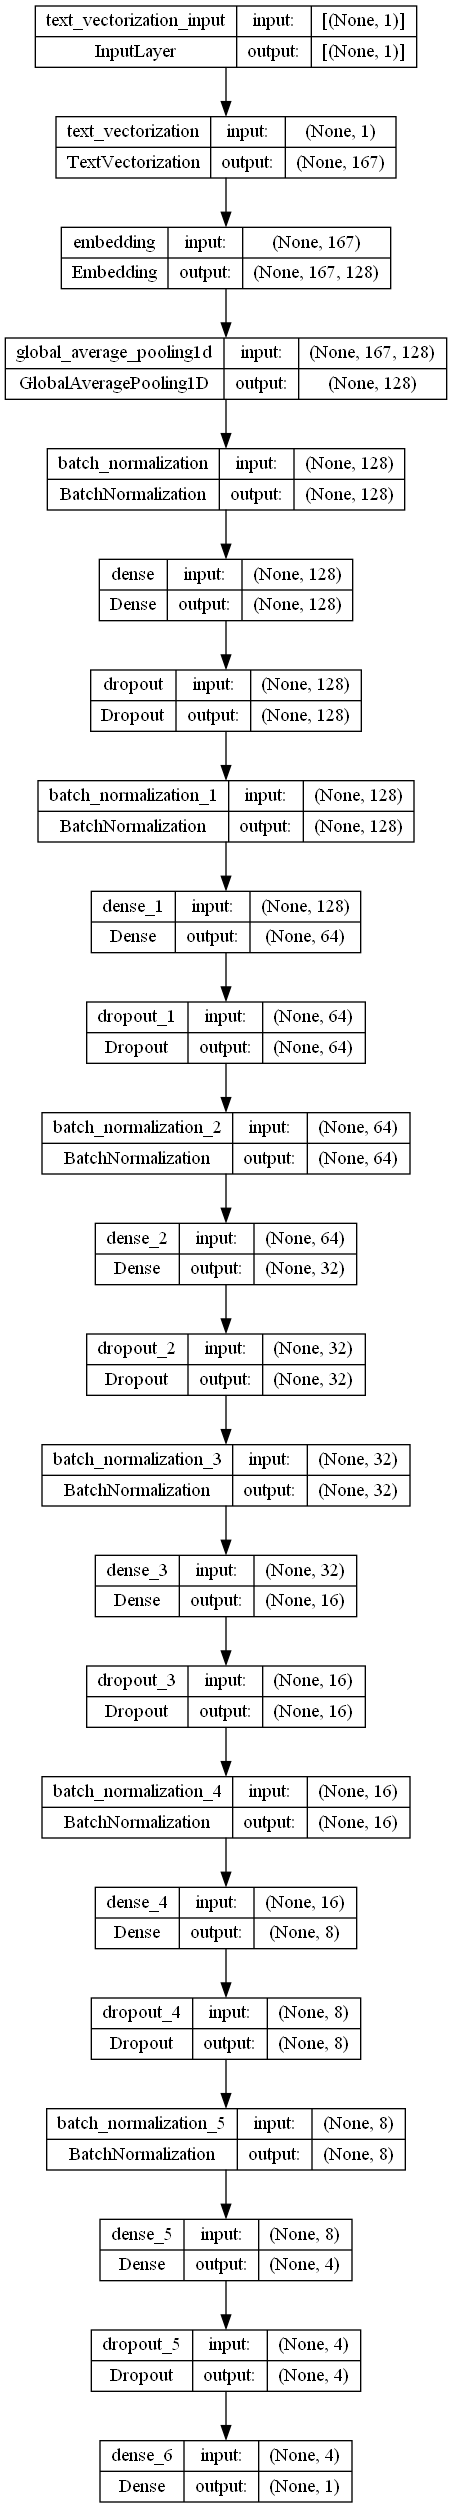

In [28]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# model architecture
model_4= Sequential()
model_4.add(text_vectorization)
model_4.add(embedding)
model_4.add(GlobalAveragePooling1D())
model_4.add(BatchNormalization())
model_4.add(Dense(128,activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(BatchNormalization())
model_4.add(Dense(64,activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(BatchNormalization())
model_4.add(Dense(32,activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(BatchNormalization())
model_4.add(Dense(16,activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(BatchNormalization())
model_4.add(Dense(8,activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(BatchNormalization())
model_4.add(Dense(4,activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(1,activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_4, show_shapes=True)

## model training

In [35]:
# model training
model_ann_hist_4 = model_4.fit(train_pipe,epochs=50,validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 10s 55ms/step - loss: 0.8714 - accuracy: 0.4953 - auc: 0.5051 - val_loss: 0.6949 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 0.7955 - accuracy: 0.5076 - auc: 0.5153 - val_loss: 0.6962 - val_accuracy: 0.4491 - val_auc: 0.4803
Epoch 3/50
17/17 [==============================] - 0s 17ms/step - loss: 0.8123 - accuracy: 0.5076 - auc: 0.4979 - val_loss: 0.6985 - val_accuracy: 0.4491 - val_auc: 0.5867
Epoch 4/50
17/17 [==============================] - 0s 16ms/step - loss: 0.7777 - accuracy: 0.5332 - auc: 0.5295 - val_loss: 0.7006 - val_accuracy: 0.4491 - val_auc: 0.3609
Epoch 5/50
17/17 [==============================] - 0s 17ms/step - loss: 0.7484 - accuracy: 0.5493 - auc: 0.5397 - val_loss: 0.7017 - val_accuracy: 0.4491 - val_auc: 0.5717
Epoch 6/50
17/17 [==============================] - 0s 17ms/step - loss: 0.7371 - accuracy: 0.5512 - auc: 0.5421 - val_loss: 0.7043 - 

## model evaluation

<AxesSubplot:>

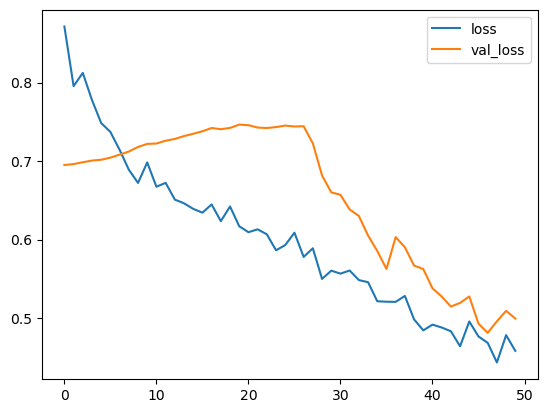

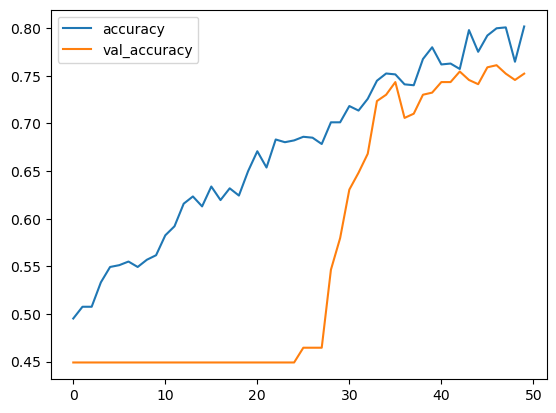

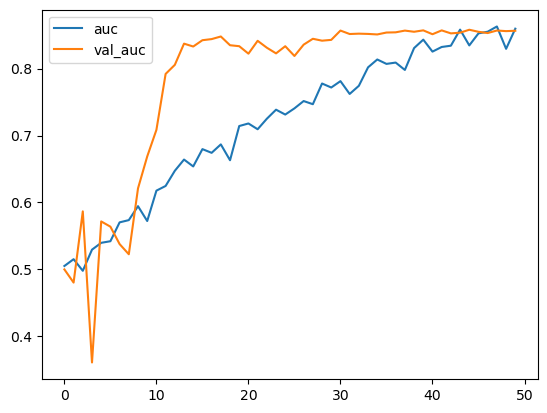

In [36]:
# melihat performansi model
metrics = pd.DataFrame(model_ann_hist_4.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [37]:
# membuat classification repot
y_pred_func = model_4.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       249
           1       0.66      0.94      0.77       203

    accuracy                           0.75       452
   macro avg       0.79      0.77      0.75       452
weighted avg       0.80      0.75      0.75       452



Overall ini merupakan model ANN yang terbaik hingga saat ini karena dari semua parameternya dari loss, accucary , dan auc nya meningkat dang dapat mengikuti dengan performa trainnya, dan juga berdasarkan classification report tingkat accuracy nya meningkat dari model sebelumnya menjadi 75%

# model 5

pada model 5 saya akan menggunakan LSTM (long short term memory) yaitu model yang  menyerupai ingatan manusia dimana semua pikiran di pengaruhi oleh ingatan jangka pendek maupun jangka panjang. Untuk memulainya saya membuat model LSTM Secara sedhana yang hanay berisikan 2 hidden layer.

## model building

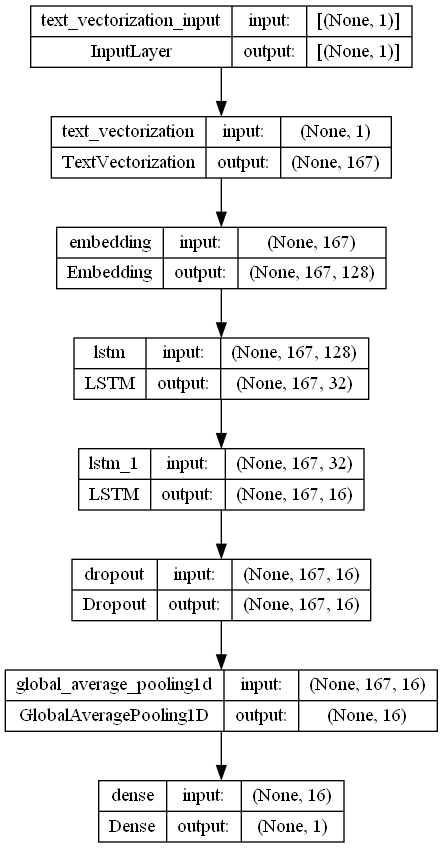

In [59]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# model architecture
model_5 = Sequential()
model_5.add(text_vectorization)
model_5.add(embedding)
model_5.add(LSTM(32, return_sequences=True))
model_5.add(LSTM(16, return_sequences=True))
model_5.add(Dropout(0.5))
model_5.add(GlobalAveragePooling1D())
model_5.add(Dense(1,activation='sigmoid'))

model_5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_5, show_shapes=True)

## model training

In [85]:

 #model training
model_ann_hist_5 = model_5.fit(train_pipe,epochs=50, validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 4s 107ms/step - loss: 0.1381 - accuracy: 0.9440 - auc: 0.9851 - val_loss: 1.0674 - val_accuracy: 0.7544 - val_auc: 0.7844
Epoch 2/50
17/17 [==============================] - 1s 85ms/step - loss: 0.1231 - accuracy: 0.9478 - auc: 0.9883 - val_loss: 1.0578 - val_accuracy: 0.7566 - val_auc: 0.7892
Epoch 3/50
17/17 [==============================] - 1s 78ms/step - loss: 0.1208 - accuracy: 0.9450 - auc: 0.9896 - val_loss: 1.0379 - val_accuracy: 0.7611 - val_auc: 0.7935
Epoch 4/50
17/17 [==============================] - 1s 82ms/step - loss: 0.1175 - accuracy: 0.9450 - auc: 0.9896 - val_loss: 1.0476 - val_accuracy: 0.7633 - val_auc: 0.7923
Epoch 5/50
17/17 [==============================] - 1s 84ms/step - loss: 0.1144 - accuracy: 0.9459 - auc: 0.9895 - val_loss: 1.0375 - val_accuracy: 0.7633 - val_auc: 0.7994
Epoch 6/50
17/17 [==============================] - 1s 87ms/step - loss: 0.1181 - accuracy: 0.9459 - auc: 0.9890 - val_loss: 0.9960 - 

## model evaluation

<AxesSubplot:>

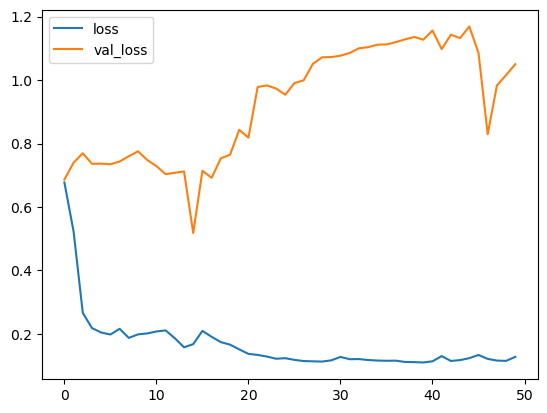

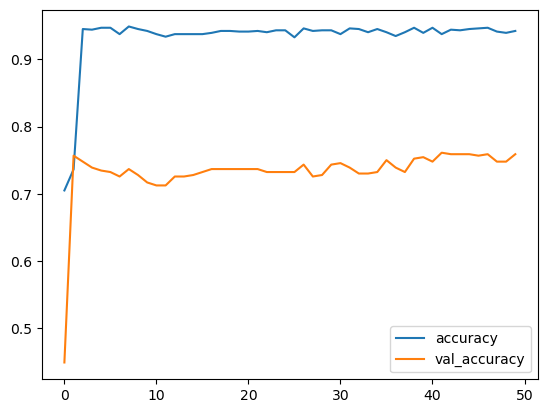

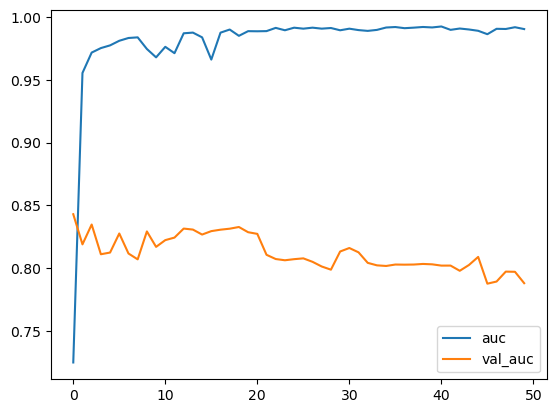

In [63]:

# melihat performansi model
metrics = pd.DataFrame(model_ann_hist_5.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [64]:
# membuat classification repot
y_pred_func = model_5.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 2s 38ms/step
              precision    recall  f1-score   support

           0       0.87      0.66      0.75       249
           1       0.68      0.88      0.77       203

    accuracy                           0.76       452
   macro avg       0.78      0.77      0.76       452
weighted avg       0.79      0.76      0.76       452



unutuk base model lstm ini cukup baik dari sisi metrick dengan berkisar 15-20% nya tetapi loss value nya masih belum stabil yang dan cenderung meningkat, mesikpun begitu tingkat akurasi nya cukup baik di sekitar 76% , Akan tetapi model LSTM ini memakan waktu train yang jauh lebih Signifikan di banding model dense yang per step nya berkisar dari 13-17 ms di model ini setiap step nya 118 ms . dan apa bila di bandingkan dengan base line model 1 meskipun ini hasilnya mirip tetapi pas evalusai model ini lebih stabil di abnding dengan model 1.

# model 6

untuk model 6 saya akan melanjutkan lstm dari model sebelumnya apakah dengan harapan menambah jumlah neuron akan mineingkatkan performa modelnya

## model building

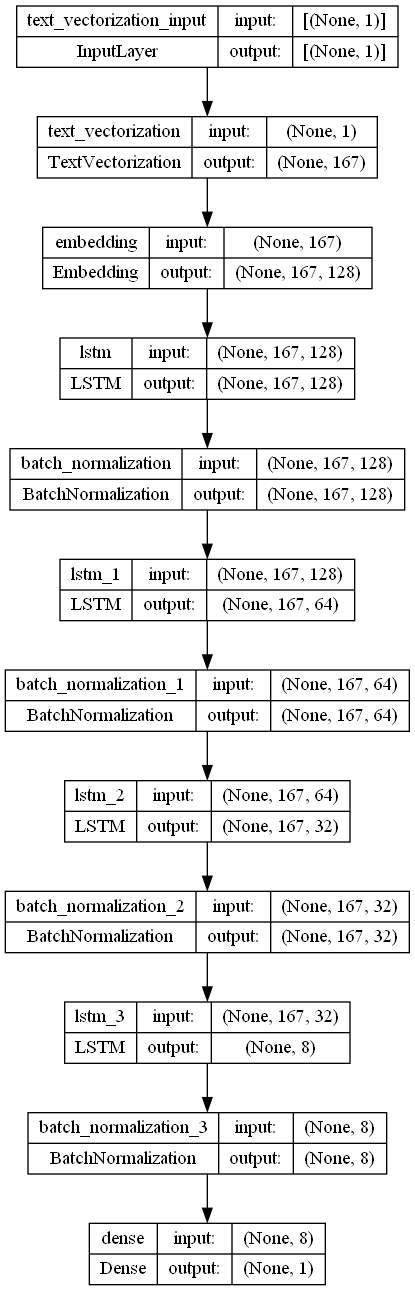

In [65]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# model architecture
model_6 = Sequential()
model_6.add(text_vectorization)
model_6.add(embedding)
model_6.add(LSTM(128, activation='relu', return_sequences=True, dropout=0.5))
model_6.add(BatchNormalization())
model_6.add(LSTM(64, activation='relu', return_sequences=True, dropout=0.5))
model_6.add(BatchNormalization())
model_6.add(LSTM(32, activation='relu', return_sequences=True, dropout=0.5))
model_6.add(BatchNormalization())
model_6.add(LSTM(8,activation='relu',  dropout=0.5))
model_6.add(BatchNormalization())
model_6.add(Dense(1,activation='sigmoid'))

model_6.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_6, show_shapes=True)

## model training

In [66]:

# model training
#model_ann_hist_6 = model_6.fit(train_pipe,epochs=50, validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 31s 990ms/step - loss: 0.7555 - accuracy: 0.5104 - auc: 0.5283 - val_loss: 0.6932 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 2/50
17/17 [==============================] - 15s 901ms/step - loss: 0.6876 - accuracy: 0.5731 - auc: 0.5711 - val_loss: 0.6925 - val_accuracy: 0.5509 - val_auc: 0.5000
Epoch 3/50
17/17 [==============================] - 15s 879ms/step - loss: 0.6578 - accuracy: 0.6252 - auc: 0.6436 - val_loss: 0.6915 - val_accuracy: 0.5553 - val_auc: 0.5029
Epoch 4/50
17/17 [==============================] - 15s 909ms/step - loss: 0.7115 - accuracy: 0.5304 - auc: 0.5270 - val_loss: 0.7174 - val_accuracy: 0.5642 - val_auc: 0.5123
Epoch 5/50
17/17 [==============================] - 15s 899ms/step - loss: 0.6927 - accuracy: 0.5161 - auc: 0.5349 - val_loss: 0.6927 - val_accuracy: 0.5487 - val_auc: 0.4980
Epoch 6/50
17/17 [==============================] - 14s 796ms/step - loss: 0.6800 - accuracy: 0.5370 - auc: 0.5486 - val_loss

## model evaluation


<AxesSubplot:>

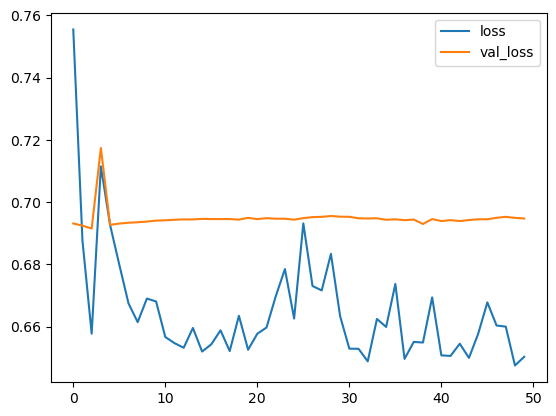

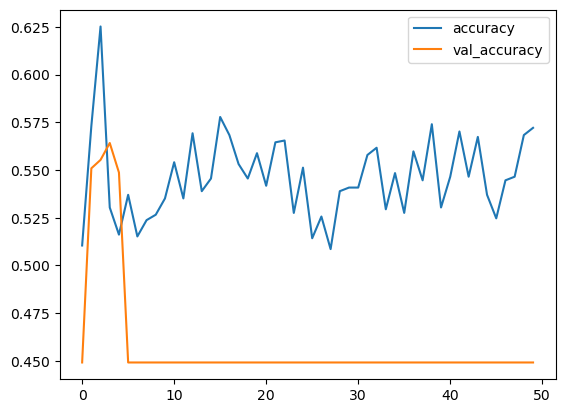

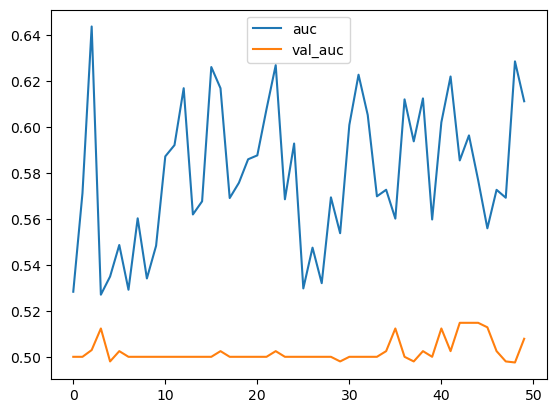

In [69]:
# melihat performansi model
metrics = pd.DataFrame(model_ann_hist_6.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [ ]:
# membuat classification repot
y_pred_func = model_6.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       249
           1       0.00      0.00      0.00       203

    accuracy                           0.55       452
   macro avg       0.28      0.50      0.36       452
weighted avg       0.30      0.55      0.39       452



Untuk model 6 ini bisa di katakan lebih buruk di banding model 5 yang lebih simple  dimana validattion nya cenderung lurus dan nilai accuracy di sekitar 55% yang terednah hingga saat ini, mungkin ini dikarenakan model yang terlalu rumit sehingga model tidak belajar tetapi hanya meningiat saja.

# model 7

Untuk model ke 7 akan menggunakan GRU yaitu model yang mirip dengan LSTM tetapi secara perhitungnya lebih simple sibanding dengan LSTM

## model building

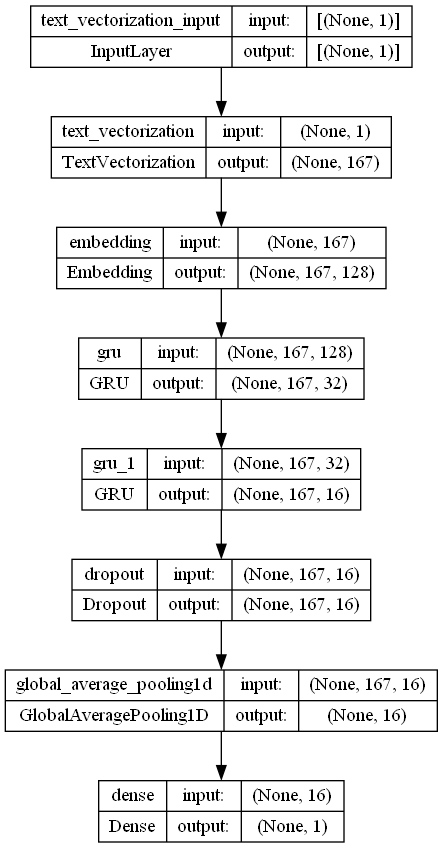

In [70]:
## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# model architecture
model_7 = Sequential()
model_7.add(text_vectorization)
model_7.add(embedding)
model_7.add(GRU(32, return_sequences=True))
model_7.add(GRU(16, return_sequences=True))
model_7.add(Dropout(0.5))
model_7.add(GlobalAveragePooling1D())
model_7.add(Dense(1,activation='sigmoid'))

model_7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_7, show_shapes=True)

## model training

In [71]:
# model training
model_ann_hist_7 = model_7.fit(train_pipe,
                         epochs=50,
                         validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 8s 114ms/step - loss: 0.6735 - accuracy: 0.5398 - auc: 0.7163 - val_loss: 0.6748 - val_accuracy: 0.5996 - val_auc: 0.8443
Epoch 2/50
17/17 [==============================] - 1s 77ms/step - loss: 0.6339 - accuracy: 0.8776 - auc: 0.9688 - val_loss: 0.6457 - val_accuracy: 0.7301 - val_auc: 0.8503
Epoch 3/50
17/17 [==============================] - 1s 78ms/step - loss: 0.5336 - accuracy: 0.9393 - auc: 0.9731 - val_loss: 0.5288 - val_accuracy: 0.7655 - val_auc: 0.8535
Epoch 4/50
17/17 [==============================] - 1s 86ms/step - loss: 0.2564 - accuracy: 0.9364 - auc: 0.9569 - val_loss: 1.2195 - val_accuracy: 0.7345 - val_auc: 0.8027
Epoch 5/50
17/17 [==============================] - 2s 110ms/step - loss: 0.2380 - accuracy: 0.9469 - auc: 0.9609 - val_loss: 1.0689 - val_accuracy: 0.7412 - val_auc: 0.8174
Epoch 6/50
17/17 [==============================] - 2s 113ms/step - loss: 0.2152 - accuracy: 0.9469 - auc: 0.9685 - val_loss: 0.9254 

## model evaluation

<AxesSubplot:>

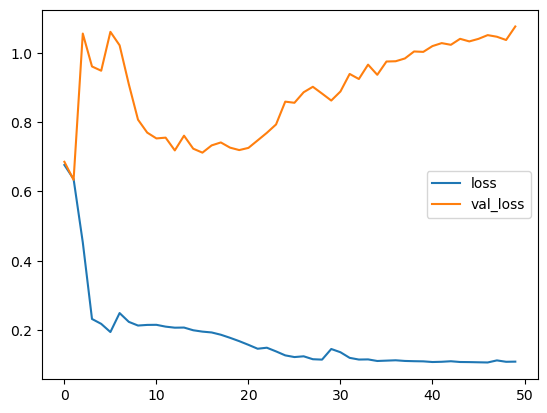

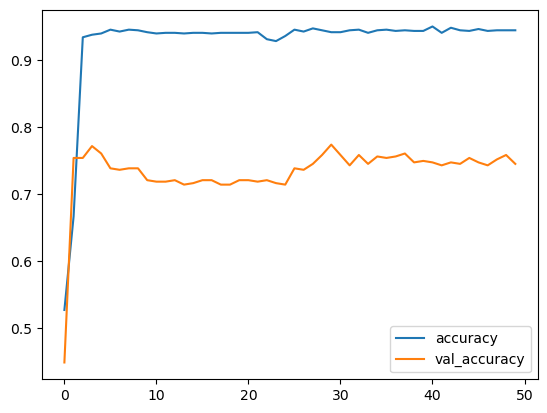

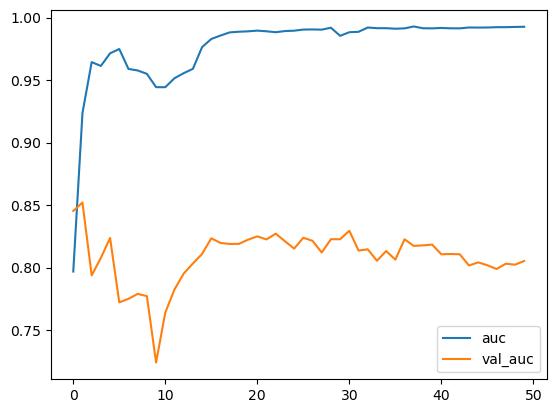

In [50]:
# melihat performansi model
metrics = pd.DataFrame(model_ann_hist_7.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [51]:

# membuat classification repot
y_pred_func = model_7.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0       0.92      0.59      0.72       249
           1       0.65      0.94      0.77       203

    accuracy                           0.75       452
   macro avg       0.79      0.76      0.74       452
weighted avg       0.80      0.75      0.74       452



Sama seperi lstm model GRU yang simple memliki performa yang cukup bagus dengan perbedan di sekitar 10-20 % tetapi stabil dan dengan accuracy 75% bisa di dikatakan model gru cukup memuaskan

# model 8

untuk model ke 8 saya ingin mencoba menggabungkan model lstm dengan dense dengan harapan dapat mendapatkan performa lstm basedline yang baik kemudian di improve dengan kestabikan dari dense model sebelumnay.

## model building

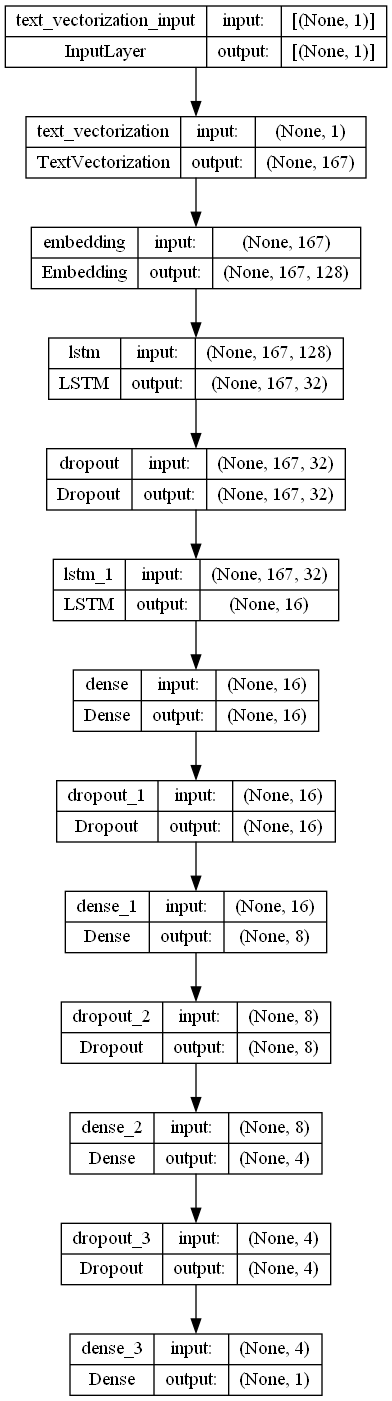

In [82]:

## reset model agar hasil konsisten
seed = 39
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# model architecture
model_b = Sequential()
model_b.add(text_vectorization)
model_b.add(embedding)
model_b.add(LSTM(32, return_sequences=True))
model_b.add(Dropout(0.5))
model_b.add(LSTM(16))
model_b.add(Dense(16,activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(8,activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(4,activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(1,activation='sigmoid'))

model_b.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC'])
tf.keras.utils.plot_model(model_b, show_shapes=True)



## model training

In [83]:
# model training
model_dnn_hist_b = model_b.fit(train_pipe,
                         epochs=50,
                         validation_data=test_pipe)

Epoch 1/50
17/17 [==============================] - 9s 138ms/step - loss: 0.6953 - accuracy: 0.5047 - auc: 0.4814 - val_loss: 0.6931 - val_accuracy: 0.5509 - val_auc: 0.5000
Epoch 2/50
17/17 [==============================] - 2s 101ms/step - loss: 0.6942 - accuracy: 0.5133 - auc: 0.4918 - val_loss: 0.6936 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 3/50
17/17 [==============================] - 2s 92ms/step - loss: 0.6937 - accuracy: 0.5247 - auc: 0.5021 - val_loss: 0.6954 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 4/50
17/17 [==============================] - 2s 97ms/step - loss: 0.6939 - accuracy: 0.5104 - auc: 0.4976 - val_loss: 0.6945 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 5/50
17/17 [==============================] - 2s 90ms/step - loss: 0.6909 - accuracy: 0.5247 - auc: 0.5411 - val_loss: 0.6959 - val_accuracy: 0.4491 - val_auc: 0.5000
Epoch 6/50
17/17 [==============================] - 2s 92ms/step - loss: 0.6918 - accuracy: 0.5275 - auc: 0.5161 - val_loss: 0.6966 -

## model evaluation

<AxesSubplot:>

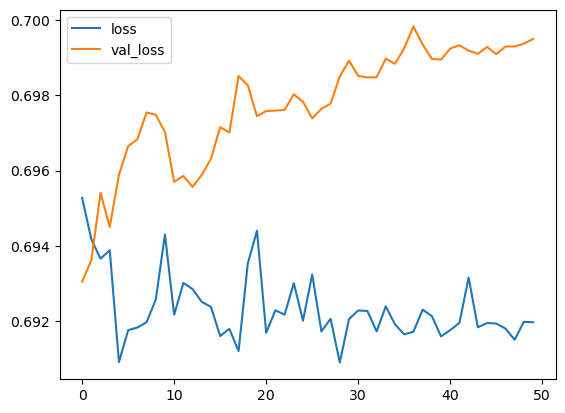

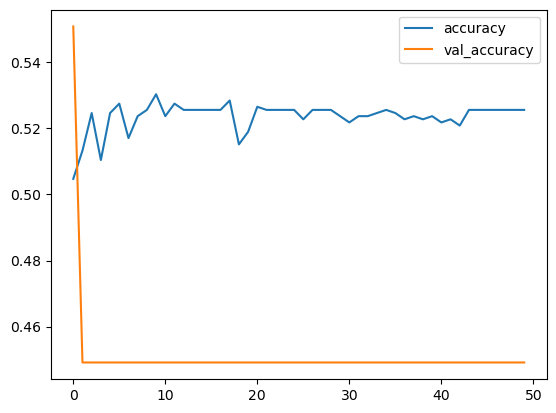

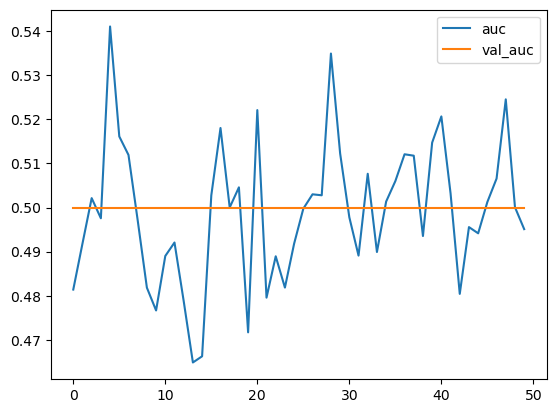

In [84]:
# melihat performansi model
metrics = pd.DataFrame(model_dnn_hist_b.history)
metrics[['loss', 'val_loss']].plot()
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['auc', 'val_auc']].plot()

In [80]:
# membuat classification repot
y_pred_func = model_b.predict(X_test)
y_pred_func = np.where(y_pred_func >=0.5, 1, 0)

print(classification_report(y_test, y_pred_func))

15/15 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       249
           1       0.45      1.00      0.62       203

    accuracy                           0.45       452
   macro avg       0.22      0.50      0.31       452
weighted avg       0.20      0.45      0.28       452



mirip sepert model 6 di mana lstm di buat lebih komplek hasil performa model 8 ini bisa di katakan jelek dengan accuracy di sekitar 45% dan model yang tidak ada peningkatan accuracy mendakan model tidak dapat belajar , mungkin ini di karenakan model yang terlalu kompleks sehingga susah untuk belajar.

# model saving

saving model for infarence

In [52]:
# saving model
model_4.save('model_4')

INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


Save data yang bersih untuk EDA

In [97]:
# saving for EDA data
teks.to_csv(r'D:\Hack8 Data Science\Phase 2\Milestone\Milestone 2\eda.csv')

# model inferance

pada bgaian ini akan memeprdiksi tingkat sentimen terhadap kata baru.

In [51]:
# masukan kata baru
kalimat_baru='semoga ahok menang'


# mengubah kata menajdi angka agar dapat di proses komputer
feature=np.array(kalimat_baru).reshape(1,-1)

# model prediction
analisis=model_4.predict(feature)
analisis= np.where(analisis>= 0.5,0,1)
analisis

1/1 [==============================] - 0s 18ms/step


array([[0]])

# Evaluation


dataset yang di gunakan adalaha data scraping dari twiter mengenai pemilu pada 2017 , dataset ini meiliki sekitar 1500 data dengan value sentimen 0 atau 1 dimana 0 ada positif dan 1 adalah segatif. 

dataset ini memiliki persebaran data yang imbang yaitu 50.3% poisitf dan 49.7% negatif, sedangkan unutk kata yang paling sering mucncul adalah nama-nama politikus dan nama calon, yang menarik dari sini ialah nama ahok yang paling sering muncul untuk sentimen yang positif maupun negatif.

untuk  modeling terdapat 8 jenis model yang terdiri dari 4 model dense, 2 model LSTM , 1 model GRU , dan 1 model hybrid LSTM-dense. unutuk model 1 yaitu model yang dense base line memiliki tingakt akurasi 77% tetapi di model ini masih memiliki masalah overfit dan vanishsing gradient problem, maka untuk model 2 di tambahkan batch normalization dengan harapan bisa menguarangi vanisng ,hasilnya model initerjadi peningkatan yang kecil anatara test dan val dan nilai accuarcy nya berubah menajdi 76%, untuk model 3 di tambah drop out dengan tujuan menggurangi masalah overfitt hasilnya kmodel meningkat signikan dengan perbedaan antara test dan val di sekitar 10% an dengan tingkat accuracy di 73%, meskipun nilai accuracy nya menurun tetapi gap dari test dan val nya membaik ini meruoakan sebuah peningkatan. Maka dari itu untuk model 4 akan menggabungkan modifikasi pada model 2 dan 3 dengan menabhakan dropout dan batch normalization harapan peningkatan terjadi lebih significant, hasilnya gap antara train dan val hampir meghilang dan juga loss nya menurun secara konsisiten mendakan bahwa model ini berhasil belajar dan menebak validasi dengan baik, tidak hanya itu juga nilai accuracy nya juga meningkat menjadi 75% ini merupakan hasil terbaik hingga saat ini.

sedangkan unutk model LSTM dan GRU , model 5 dan 7 yaitu model LSTm dan GRU yang simple dengan 2 layer memiki hasil yang mirip dimana gap anatara train dan val nya berada di sekitar 10-13% ini merupakan hasil yang cukup baik unutk di gunakan sebgagai base model, tetapi apabial di tambahakan model manjai komplek seperti model 6 dimana LSTM menjadi 4 layer hasilnya mejadi lebih buruk dimana nialai val nya hanya garis lurus tidak ada peningkatan selama prosses train ini menggbarakan bahwa model tidak dapat belajat mungkin dikarenakan model yang terlalu komplek., ini juga terjadi di model 8 dimana saya menggabukan LSTM dengan dense model tidak dapat belajar sehingga niali valnya hanya lurus.

unutk model yang saya pilih adalah model 4 dengan alasan performa train-val nya yang hampir sama menndakan ke konsistenan model dalam belajar dan mengevalusainya.

Kesimpulan untuk model:
- untuk model dense menabhakan batch normalization dan dropout dapat meningkatakan performa model untuk dataset yang dimiliki
- Untuk model yang berbasis LSTM dan GRU sebaik nya hanya menggunakan model yang simple( 2 hidden layer) , karena di percobaan terlihat model yang komplek membuat performa menajdi lebih buruk.



Insight dan Takeaway :
- karena data set ini mengenai pemilu ada bayak kerancuan seperti paslon 1,2 atau si-1 membuat model susah dan satir seperti hebat ya korupsi merajalela  yang ada , ini membuat proses training lebih susah.
- Dapat menggunakan libaray data set yang lebih lebar untuk trainig kemudian baru melakukan prediksi di model ini.
- untuk futre imporevemnt dapat belajar menggunakan lexicon slag atau informal yang biasa di gunkan orang indonesia agak lebih mampu mengtahui maksud drai kata yang bisa di gunakan.